# Forecasting using Autogluon

## Preparing the Dataset

Let's take a look first at the raw data:

In [1]:
%load_ext autoreload
%autoreload 2

import os
WORKING_DIRECTORY: str = "/Users/cgavidia-calderon/Documents/GitHub/OpenMarsML/dust_forecast"
os.chdir(WORKING_DIRECTORY)

import logging
logging.basicConfig(level=logging.INFO)

from data_utils import DATETIME_COLUMN
import pandas as pd
TRAINING_DATA_FILE: str = "/Users/cgavidia-calderon/Documents/GitHub/OpenMarsML/data/data_files/insight_openmars_training_time.csv"


training_dataframe: pd.DataFrame = pd.read_csv(TRAINING_DATA_FILE, parse_dates=[DATETIME_COLUMN])
training_dataframe


,Time,Ls,LT,Tsurf,Psurf,CO2ice,cloud,vapour,u_wind,v_wind,dust,temp
0,1998-07-15 21:23:39,0.555,9.0,264.042,721.113,0.0,0.092,0.027,-7.451,8.604,0.428,179.686
1,1998-07-15 23:26:53,0.598,11.0,274.736,705.090,0.0,0.145,0.026,-7.053,4.934,0.427,174.502
2,1998-07-16 01:30:07,0.640,13.0,265.939,700.691,0.0,0.105,0.026,-6.825,-0.063,0.427,173.429
3,1998-07-16 03:33:21,0.683,15.0,238.624,697.252,0.0,0.134,0.025,-5.373,-4.048,0.426,173.556
4,1998-07-16 05:36:35,0.725,17.0,213.634,717.146,0.0,0.139,0.026,-3.899,-3.133,0.426,174.789
...,...,...,...,...,...,...,...,...,...,...,...,...
72191,2015-06-18 04:24:40,359.795,7.0,235.054,730.498,0.0,0.019,0.014,1.868,8.633,0.388,191.498
72192,2015-06-18 06:27:53,359.838,9.0,264.949,730.753,0.0,0.015,0.014,-6.924,6.590,0.388,187.591
72193,2015-06-18 08:31:07,359.880,11.0,275.776,703.987,0.0,0.012,0.014,-4.681,2.727,0.388,185.172
72194,2015-06-18 10:34:21,359.923,13.0,266.946,695.836,0.0,0.012,0.014,-3.277,-5.484,0.388,184.216


In [2]:
training_dataframe.describe()

,Time,Ls,LT,Tsurf,Psurf,CO2ice,cloud,vapour,u_wind,v_wind,dust,temp
count,72196,72196.000000,72196.000000,72196.000000,72196.000000,72196.0,72196.000000,72196.000000,72196.000000,72196.00000,72196.000000,72196.000000
mean,2006-12-31 17:25:41.788063232,169.699903,12.000000,221.822267,731.683035,0.0,0.038435,0.015826,0.220215,1.44027,0.457868,184.425504
min,1998-07-15 21:23:39,0.000000,1.000000,179.021000,593.572000,0.0,0.000000,0.002000,-18.546000,-20.31800,0.000000,144.080000
25%,2002-10-08 06:05:25,78.234000,7.000000,195.718000,696.571000,0.0,0.000000,0.013000,-2.480000,-1.61825,0.216000,175.625750
50%,2006-12-31 17:47:42,159.002500,12.000000,209.725500,738.898000,0.0,0.011000,0.015000,0.807000,1.52050,0.346000,184.401000
75%,2011-03-26 04:43:14,261.545750,17.000000,248.303250,767.305250,0.0,0.055000,0.018000,2.405000,4.18100,0.544000,194.807250
max,2015-06-18 12:37:35,359.992000,23.000000,289.984000,841.617000,0.0,0.863000,0.038000,17.213000,17.50300,5.333000,242.430000
std,NaN,105.241749,6.903982,30.912305,47.995385,0.0,0.060889,0.004600,4.060972,4.91390,0.439075,14.658462


We have data from 1998 to 2015. Not sure if its evenly sampled though. Let's try to transform this to wide format:

In [3]:
from data_utils import to_wide_format

wide_training_dataframe: pd.DataFrame = to_wide_format(training_dataframe, time_column=DATETIME_COLUMN)
wide_training_dataframe

INFO:root:Metric: Ls Time steps: 72196
INFO:root:Metric: LT Time steps: 72196
INFO:root:Metric: Tsurf Time steps: 72196
INFO:root:Metric: Psurf Time steps: 72196
INFO:root:Metric: CO2ice Time steps: 72196
INFO:root:Metric: cloud Time steps: 72196


INFO:root:Metric: vapour Time steps: 72196
INFO:root:Metric: u_wind Time steps: 72196
INFO:root:Metric: v_wind Time steps: 72196
INFO:root:Metric: dust Time steps: 72196
INFO:root:Metric: temp Time steps: 72196
INFO:root:Number of metrics: 11


,Time,target,Metric
0,1998-07-15 21:23:39,0.555,Ls
1,1998-07-15 23:26:53,0.598,Ls
2,1998-07-16 01:30:07,0.640,Ls
3,1998-07-16 03:33:21,0.683,Ls
4,1998-07-16 05:36:35,0.725,Ls
...,...,...,...
72191,2015-06-18 04:24:40,191.498,temp
72192,2015-06-18 06:27:53,187.591,temp
72193,2015-06-18 08:31:07,185.172,temp
72194,2015-06-18 10:34:21,184.216,temp


11 time series, and 70K time steps. If recall correctly, data is sampled every two hours.

## Attempting a Forecast

First, let's create a `TimeSeriesDataFrame` instance. We are not including static features per time series.

In [4]:
from autogluon.timeseries import TimeSeriesDataFrame
from data_utils import METRIC_COLUMN, DATETIME_COLUMN

FREQUENCY: str = "2H"
PREDICTION_LENGTH: int = 10
PATH: str = "autogluon-openmars-2H"
EVALUATION_METRIC: str = "MASE"
PRESETS: str = "best_quality"
TIME_LIMIT: int = 4 * 60 * 60

time_series_dataframe: TimeSeriesDataFrame = TimeSeriesDataFrame.from_data_frame(
    wide_training_dataframe,
    id_column=METRIC_COLUMN,
    timestamp_column=DATETIME_COLUMN,
)

time_series_dataframe = time_series_dataframe.convert_frequency(freq=FREQUENCY)

training_time_series, testing_time_series = time_series_dataframe.train_test_split(PREDICTION_LENGTH)

training_time_series

/Users/cgavidia-calderon/miniconda3/envs/openmars/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


target
item_id timestamp                   
Ls      1998-07-15 20:00:00    0.555
        1998-07-15 22:00:00    0.598
        1998-07-16 00:00:00    0.640
        1998-07-16 02:00:00    0.683
        1998-07-16 04:00:00    0.725
...                              ...
temp    2015-06-17 08:00:00  186.714
        2015-06-17 10:00:00  188.496
        2015-06-17 12:00:00      NaN
        2015-06-17 14:00:00  187.265
        2015-06-17 16:00:00  187.394

[815881 rows x 1 columns]

Now, let's create the predictor instance. The ``NN5 Daily`` dataset has 111 time series with 80K time steps, and the prediction length is 56. Also the ``CIF 2016`` dataset has 72 time series and 6K time steps has a prediction length of 12. 

Let's start with 10.

In [5]:
from autogluon.timeseries import TimeSeriesPredictor

time_series_predictor: TimeSeriesPredictor = TimeSeriesPredictor(
    prediction_length=PREDICTION_LENGTH,
    eval_metric=EVALUATION_METRIC
    # path=PATH,
)
    
time_series_predictor.fit(
    training_time_series,
    presets=PRESETS,
    time_limit=TIME_LIMIT
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240401_061039"
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240401_061039'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.14
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Sun Dec 17 22:12:45 PST 2023; root:xnu-8796.141.3.703.2~2/RELEASE_ARM64_T6000
CPU Count:          10
GPU Count:          0
Memory Avail:       9.27 GB / 32.00 GB (29.0%)
Disk Space Avail:   694.50 GB / 926.35 GB (75.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 10,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequenc

Now, let's check the forecast on the training data:

In [6]:
training_predictions = time_series_predictor.predict(
    training_time_series)
training_predictions.head()

data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
Ls      2015-06-17 18:00:00  359.533883  359.043608  359.246375  359.360299   
        2015-06-17 20:00:00  359.568993  359.067263  359.249197  359.377196   
        2015-06-17 22:00:00  359.578000  359.032752  359.224692  359.367038   
        2015-06-18 00:00:00  359.641121  359.052196  359.268199  359.387562   
        2015-06-18 02:00:00  359.655474  359.044826  359.287887  359.426990   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
Ls      2015-06-17 18:00:00  359.456263  359.533883  359.637461  359.724651   
        2015-06-17 20:00:00  359.466981  359.568993  359.657620  359.764149   
        2015-06-17 22:00:00  359.478549  359.578000  359.668226  359.779931   
        2015-06-18 00:00:00  359.531868  359.641121  359.745355  359.869073   
        2015-06-18 02:00:00  359.537957  359.655474  359.772101  359.887201   

                                    0.8         0.9  
item_id timestamp                                    
Ls      2015-06-17 18:00:00  359.849843  360.044911  
        2015-06-17 20:00:00  359.868819  360.061807  
        2015-06-17 22:00:00  359.938257  360.202379  
        2015-06-18 00:00:00  360.013196  360.262492  
        2015-06-18 02:00:00  360.022653  360.235363

And let's plot the forecast for dust:

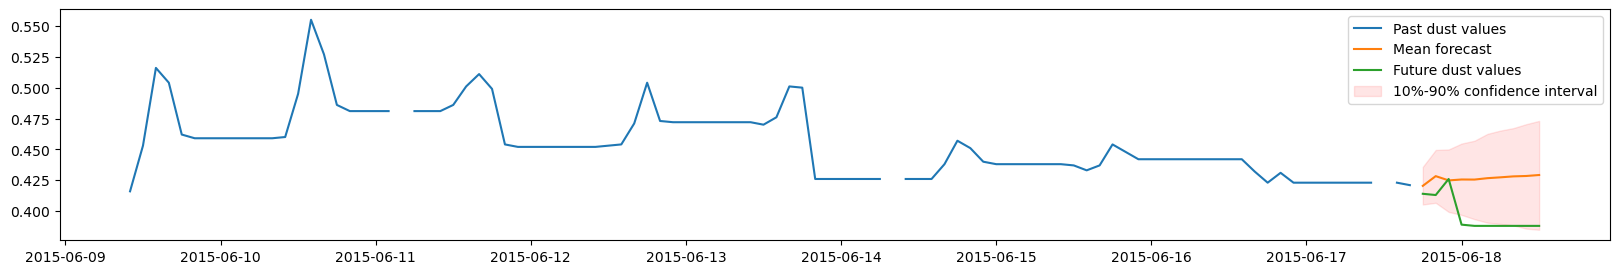

In [7]:
from plot_utils import plot_forecast

TIME_SERIES_ID: str = "dust"

plot_forecast(training_time_series, testing_time_series, training_predictions, TIME_SERIES_ID,
    PREDICTION_LENGTH, training_values=100)

## Model Evaluation

Let's take a look at what AutoGluon tried during training, over the testing time series:

In [8]:
time_series_predictor.leaderboard(testing_time_series)

data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,TemporalFusionTransformer,-0.656162,-0.574694,0.297663,0.302396,868.375464,10
1,RecursiveTabular,-0.677121,-0.510365,0.957224,1.202752,1304.658512,7
2,WeightedEnsemble,-0.774429,-0.487343,30.978834,36.784642,0.697423,12
3,DeepAR,-0.839007,-0.629064,0.517137,0.450510,774.646785,9
4,PatchTST,-0.878226,-0.687122,0.140633,0.125077,308.369993,11
5,AutoARIMA,-1.354005,-0.574900,16.875227,23.761544,0.323582,6
6,SeasonalNaive,-1.397256,-0.636861,0.098711,2.968038,0.341511,1
7,AutoETS,-2.291547,-0.808610,12.181135,10.942362,0.331344,4
8,DynamicOptimizedTheta,-2.789396,-3.145610,5.783429,5.337750,0.326492,5
9,CrostonSBA,-5.051286,-4.497837,0.964736,4.614136,0.342056,2
